In [11]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
import statsmodels.api as sm

In [12]:
warnings.filterwarnings("ignore")

In [13]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()
    
def plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half):
    plt.figure(figsize=(10, 6))
    plt.scatter(column.index, column, label='Original Values')
    plt.plot(column.index, linear_a * column.index + linear_b, color='red', label='Linear Regression')
    plt.plot(column.index, linear_a_half * column.index + linear_b_half, color='green', label='Recent Linear Regression')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Original Values vs. Linear Regression vs. Recent Linear Regression')
    plt.grid(True)
    plt.show()

In [14]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [15]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column

def extract_valid_values(column):
    valid_values = []
    valid_indexes = []
    for index, value in enumerate(column):
        if not pd.isnull(value) and not np.isnan(value):
            valid_values.append(value)
            valid_indexes.append(index)
    extracted_column = pd.Series(
        valid_values,
        index=valid_indexes
    )
    return extracted_column

def linear_regression_first_four_filler(column):
    size = len(column) - 1
    processed_column = extract_valid_values(column)
    mean_valid_values_quarter = processed_column.mean()/4
    mean_valid_values_quarter_upper = processed_column.mean() + mean_valid_values_quarter
    
    model = sm.OLS(processed_column, sm.add_constant(processed_column.index))
    result = model.fit()
    linear_a = result.params[1]
    linear_b = result.params['const']
    half_column = processed_column[:(len(processed_column) // 2)]
    model2 = sm.OLS(half_column, sm.add_constant(half_column.index))
    result2 = model2.fit()
    linear_a_half = result2.params[1]
    linear_b_half = result2.params['const']
    
    for i in range(0,4):
        if pd.isnull(column.at[i]) or np.isnan(column.at[i]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[i] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[i] = mean_valid_values_quarter_upper
            else:
                column.at[i] = projected
        x = size - 4 + i
        if pd.isnull(column.at[x]) or np.isnan(column.at[x]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[x] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[x] = mean_valid_values_quarter_upper
            else:
                column.at[x] = projected
    plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half)
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [16]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = linear_regression_first_four_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
                df[col] = df[col].apply(replace_negative_with_float_zeros)
            i += 1
        return df

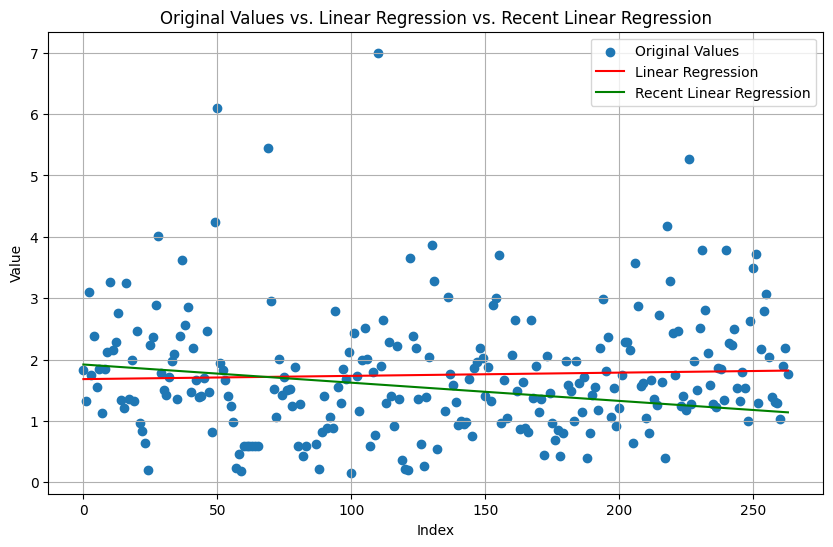

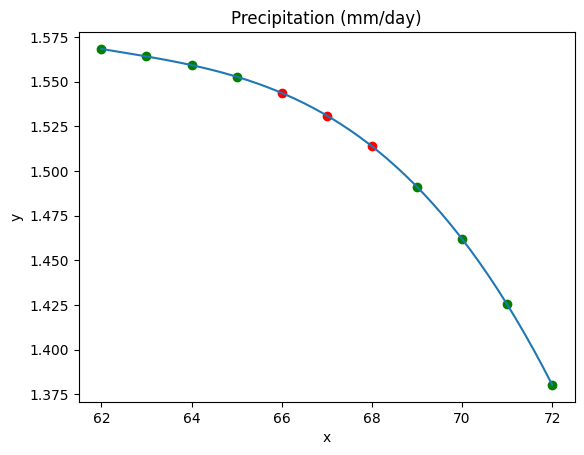

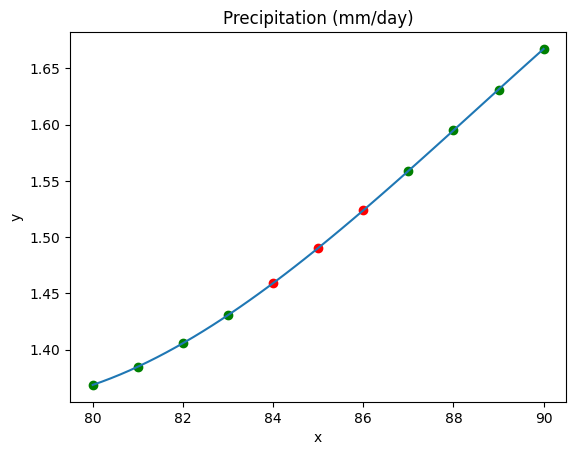

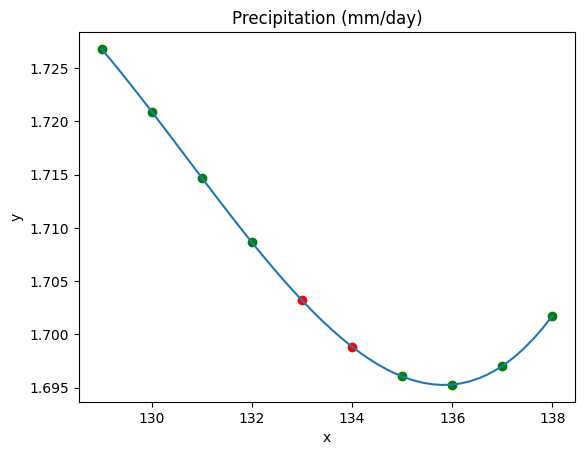

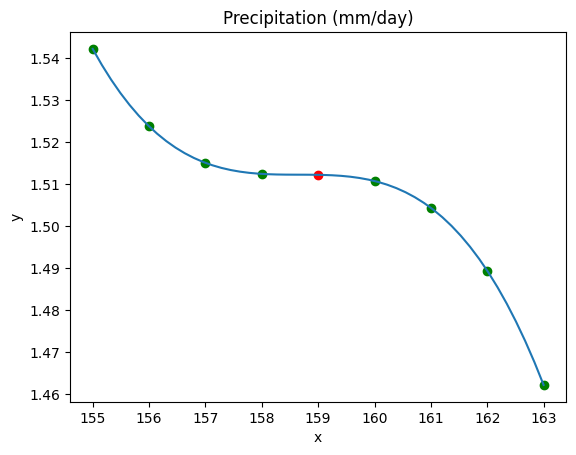

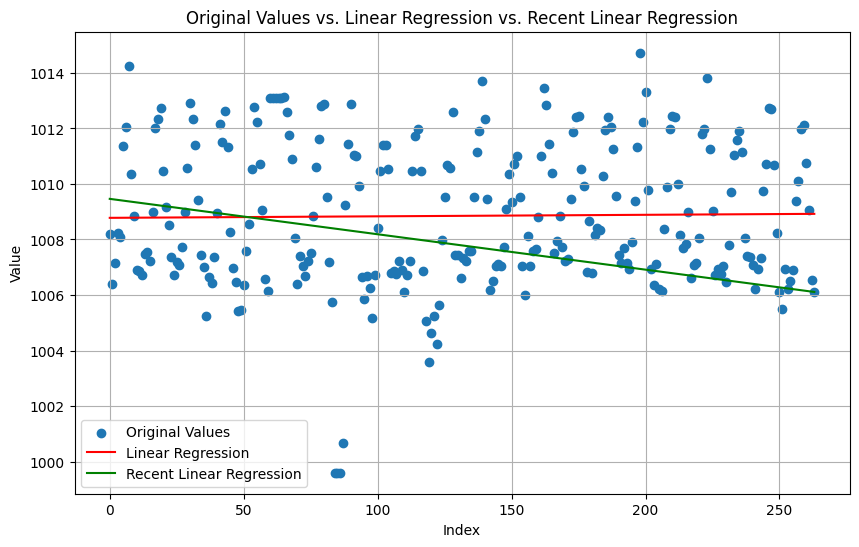

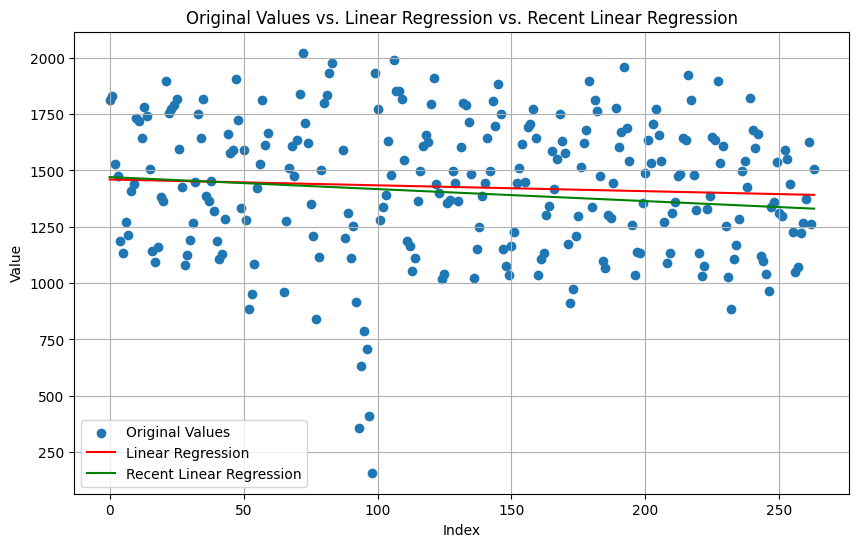

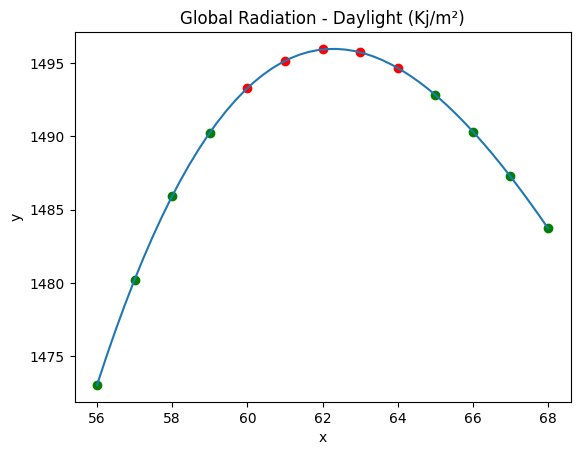

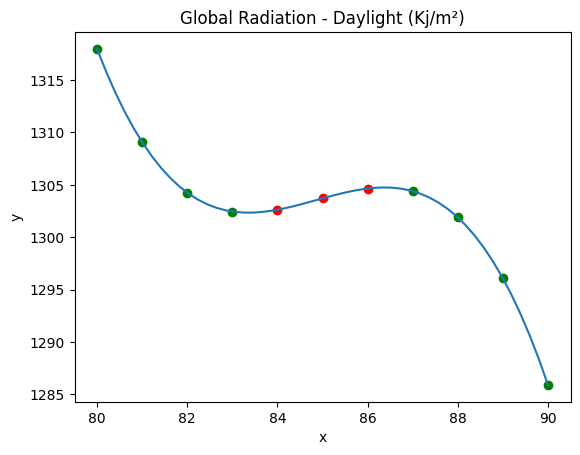

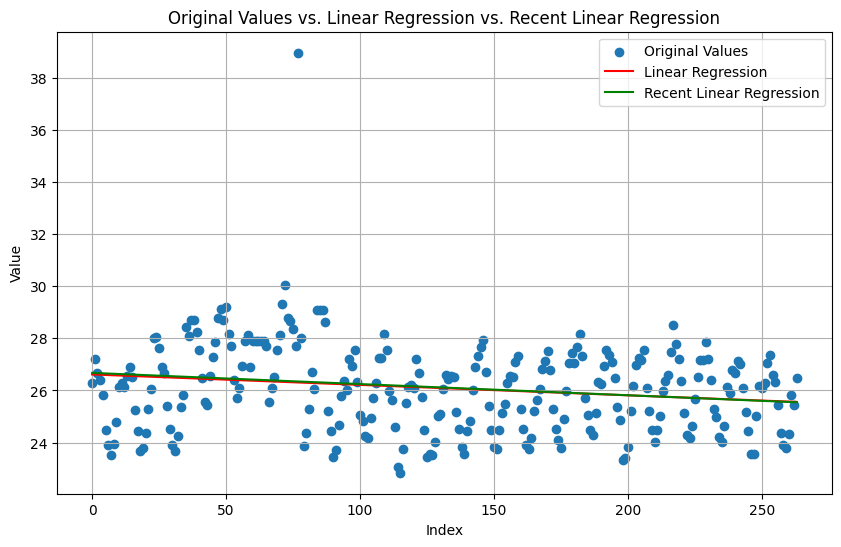

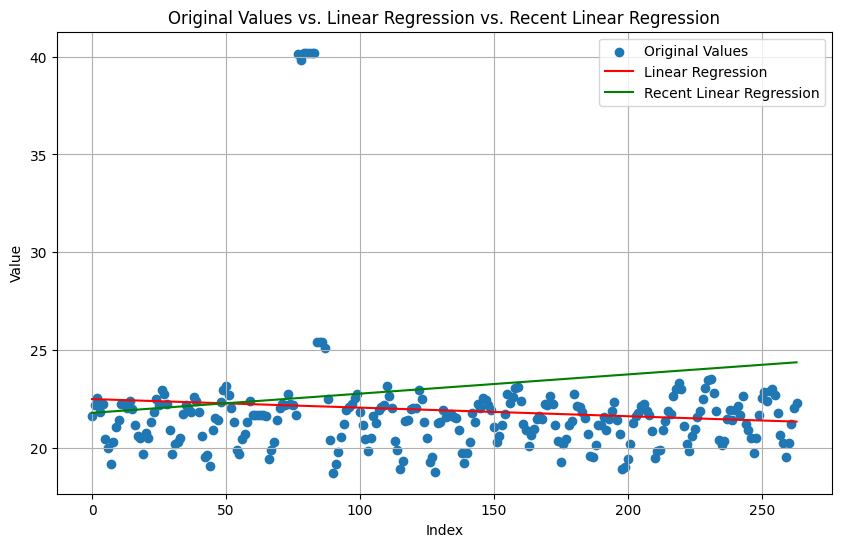

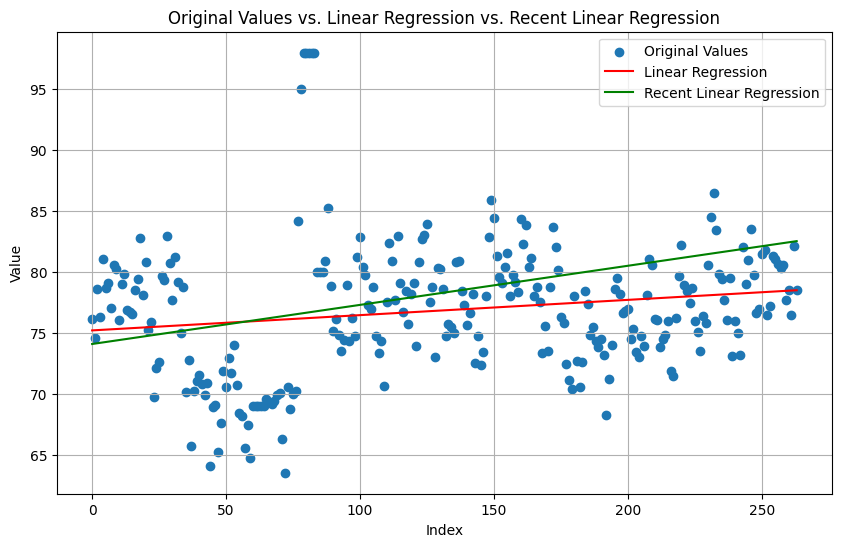

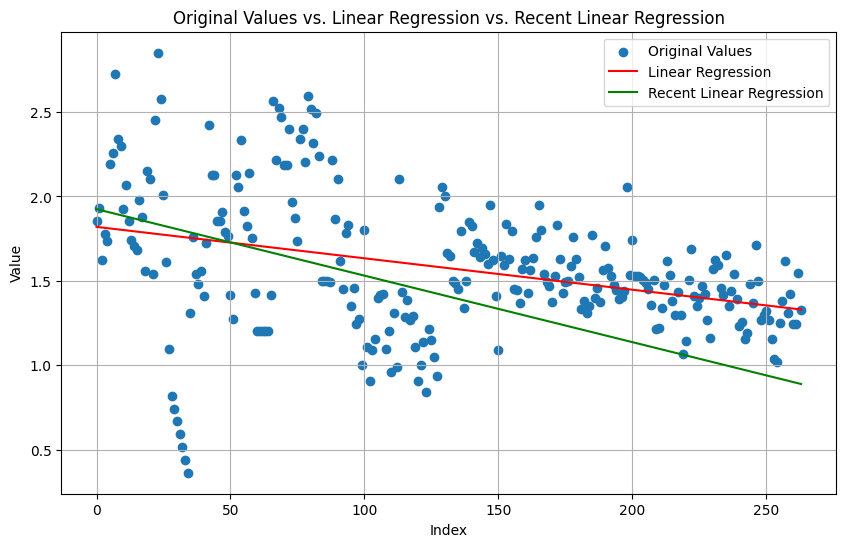

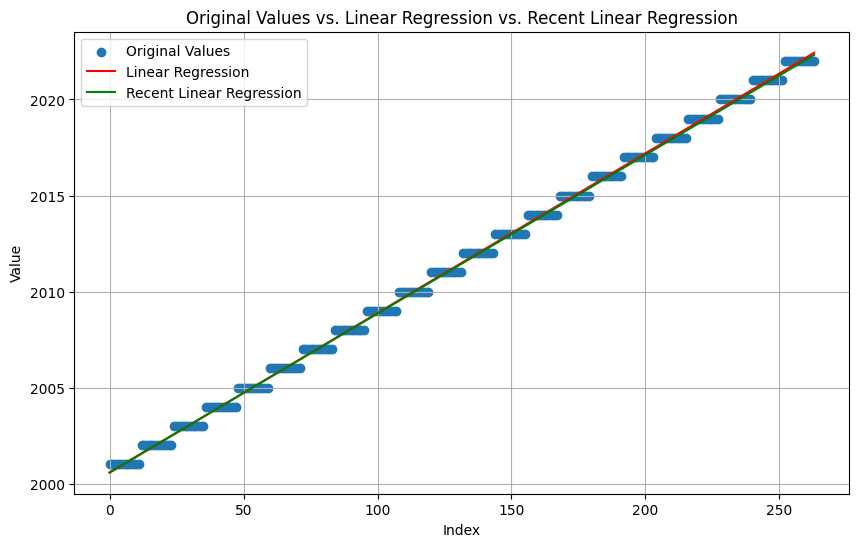

,Ano,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
0,2001,1.797721,1009.041603,1511.395421,25.620262,21.306634,77.597160,2.032070
1,2001,1.813408,1009.002400,1511.476317,25.672615,21.327705,77.461014,2.037893
2,2001,1.852387,1009.027412,1502.639787,25.660905,21.357819,77.649357,2.026146
3,2001,1.845158,1009.047743,1498.954851,25.662034,21.365629,77.675825,2.007495
4,2001,1.923322,1009.073556,1485.252565,25.627140,21.378732,77.904808,1.974419
...,...,...,...,...,...,...,...,...
259,2022,1.943973,1008.829088,1370.603147,25.569127,21.452413,78.642429,1.360082
260,2022,1.964816,1008.708626,1373.933485,25.626896,21.518137,78.692224,1.357151
261,2022,1.997203,1008.627620,1373.681799,25.670964,21.565715,78.717939,1.360803
262,2022,1.999973,1008.604028,1363.516809,25.661622,21.579755,78.825568,1.365004


In [17]:
df = read_csv_replace_missing_by_polynomial('bahia_variacao_climatica.csv', 0, 1)
df.rename(columns={'Date': 'Ano'}, inplace=True)
df['Ano'] = df['Ano'].str[:4].astype(int)
df.drop(columns='State', inplace=True)
df.drop(columns='Year', inplace=True)
df.head(len(df))

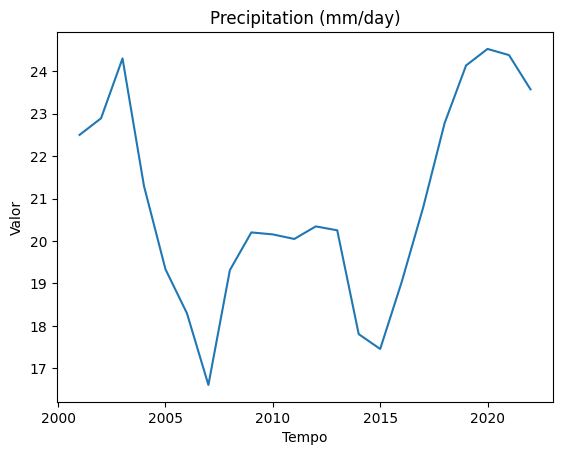

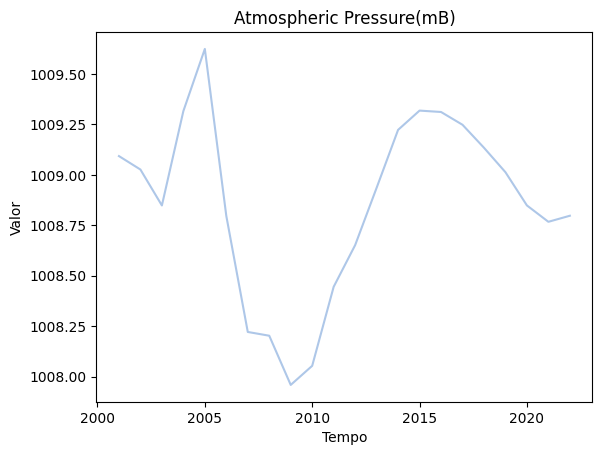

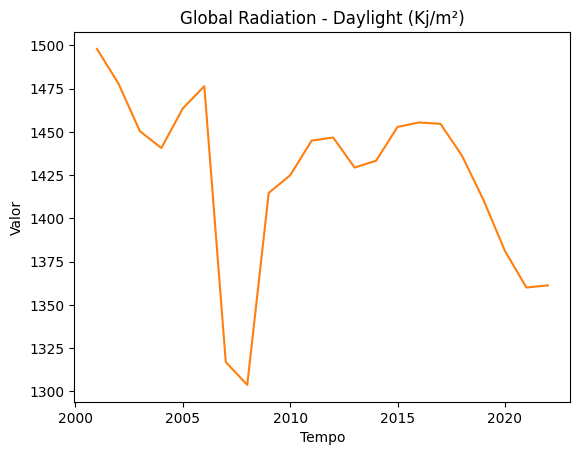

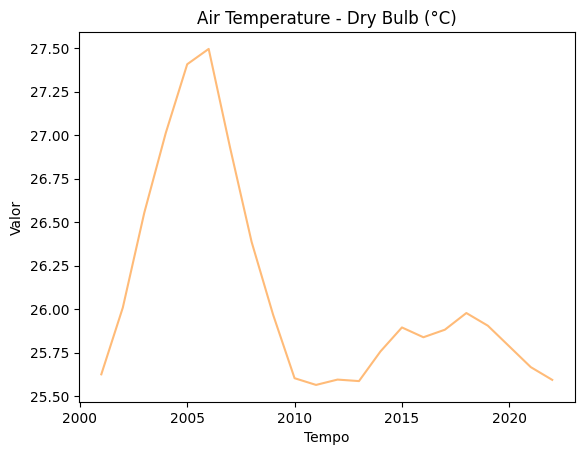

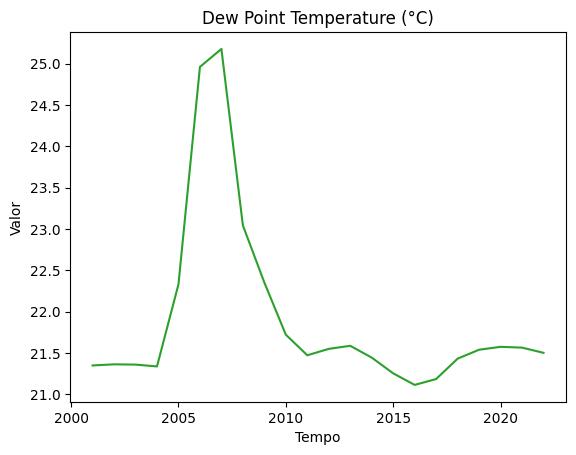

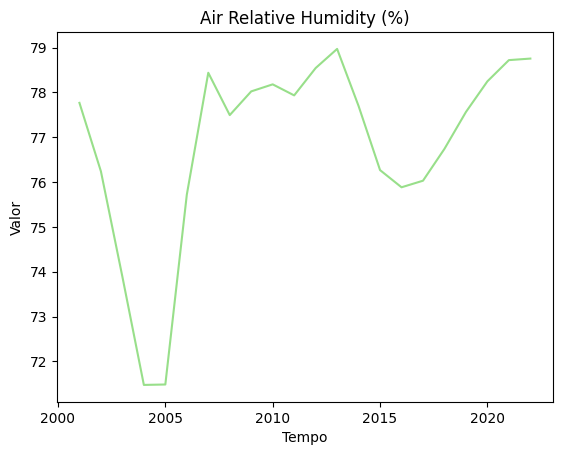

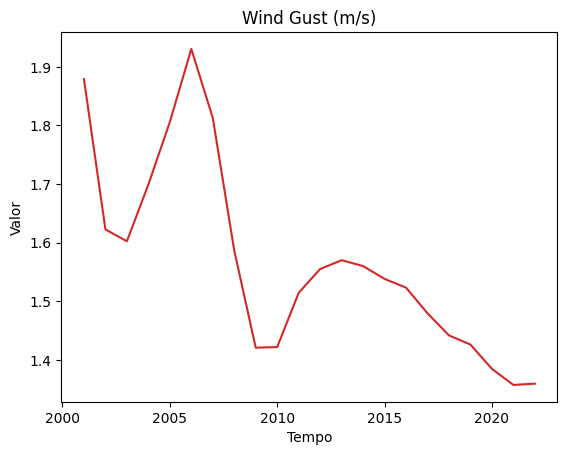

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2001,22.499817,1009.093274,1497.959022,25.625853,21.346982,77.766515,1.879068
2002,22.891005,1009.026642,1477.992646,26.008819,21.360766,76.238632,1.622734
2003,24.300584,1008.848463,1450.396879,26.553801,21.357384,73.888459,1.602501
2004,21.294803,1009.316342,1440.688900,27.012171,21.335315,71.475857,1.699240
2005,19.335488,1009.624655,1463.593390,27.407729,22.328906,71.485298,1.805776
2006,18.298188,1008.796616,1476.411920,27.495790,24.960940,75.718102,1.930499
2007,16.610190,1008.221260,1316.981695,26.926661,25.178638,78.437621,1.812937
2008,19.314465,1008.202617,1303.749515,26.386473,23.042487,77.493797,1.586819
2009,20.202505,1007.958668,1414.729195,25.968454,22.350784,78.022515,1.421020


In [18]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
df_year = df_year.groupby('Ano').mean()
df_year['Precipitation (mm/day)'] = df_year['Precipitation (mm/day)'] * 12
plot_columns(df_year)
df_year

In [19]:
df_2003 = df_year[df_year.index >= 2003]
df_2003

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2003,24.300584,1008.848463,1450.396879,26.553801,21.357384,73.888459,1.602501
2004,21.294803,1009.316342,1440.688900,27.012171,21.335315,71.475857,1.699240
2005,19.335488,1009.624655,1463.593390,27.407729,22.328906,71.485298,1.805776
2006,18.298188,1008.796616,1476.411920,27.495790,24.960940,75.718102,1.930499
2007,16.610190,1008.221260,1316.981695,26.926661,25.178638,78.437621,1.812937
2008,19.314465,1008.202617,1303.749515,26.386473,23.042487,77.493797,1.586819
2009,20.202505,1007.958668,1414.729195,25.968454,22.350784,78.022515,1.421020
2010,20.155807,1008.053425,1424.927462,25.603573,21.719583,78.179391,1.422041
2011,20.048279,1008.445156,1444.966819,25.564945,21.470218,77.933380,1.514544


In [20]:
df_2003.to_csv('2003_01_meteo.csv', index=True)

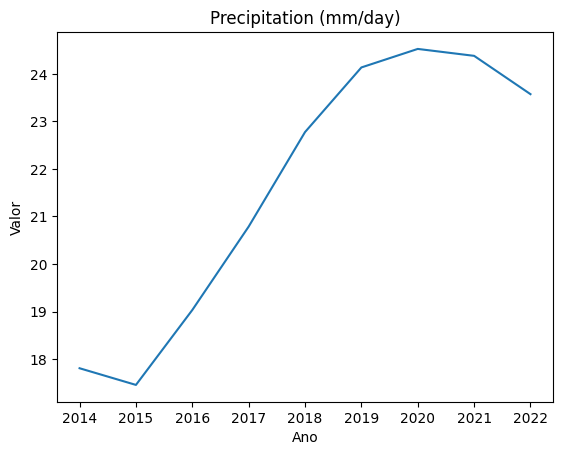

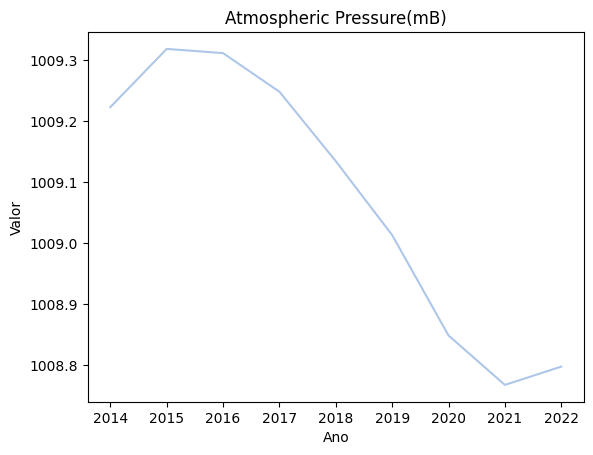

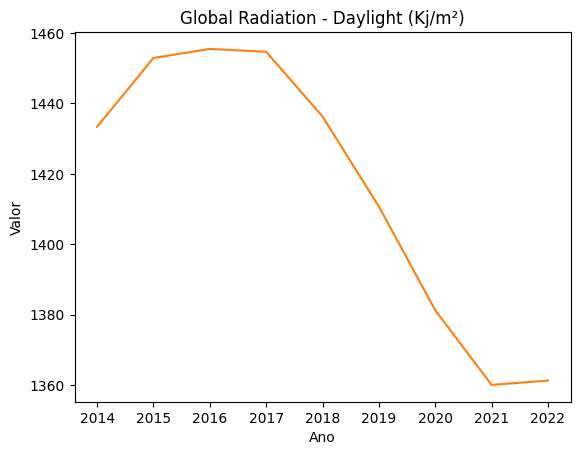

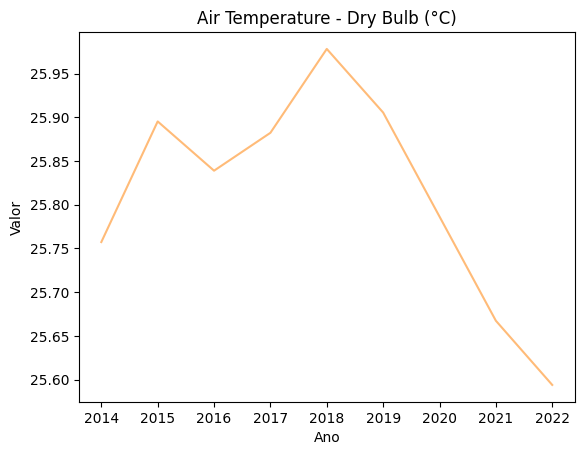

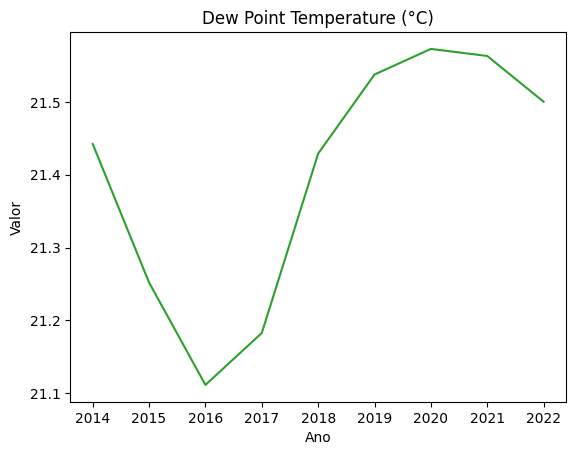

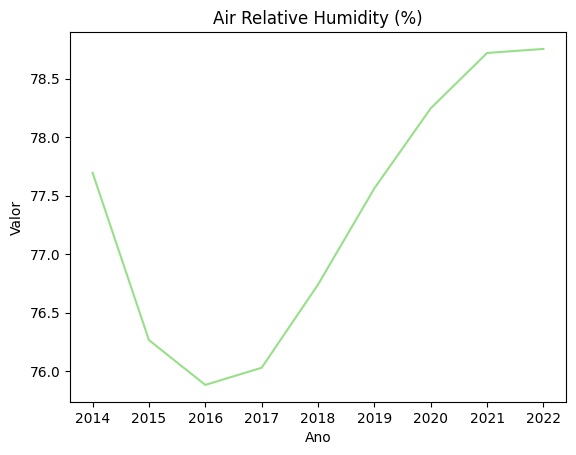

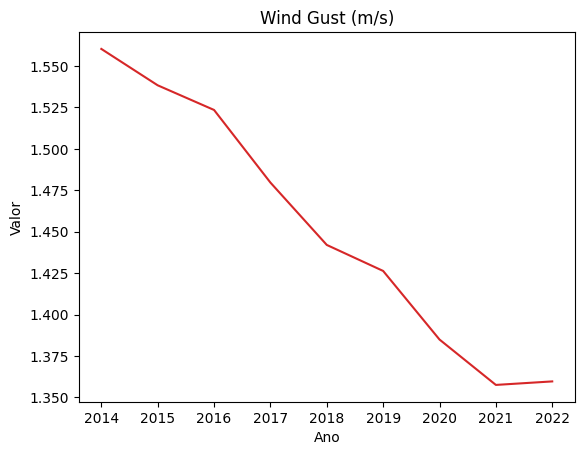

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2014,17.807272,1009.223255,1433.335843,25.757283,21.442184,77.696073,1.560276
2015,17.456441,1009.318844,1452.882864,25.895216,21.251973,76.266812,1.538323
2016,19.032574,1009.311974,1455.457303,25.838885,21.111445,75.883665,1.523445
2017,20.787217,1009.248599,1454.646572,25.882215,21.182739,76.030495,1.479634
2018,22.775724,1009.134643,1436.269378,25.978127,21.428942,76.741102,1.442002
2019,24.135441,1009.013381,1410.720023,25.905393,21.537464,77.563415,1.426308
2020,24.524983,1008.848646,1381.243545,25.786443,21.572588,78.247041,1.384922
2021,24.379330,1008.767461,1360.052394,25.667301,21.562918,78.719783,1.357531
2022,23.573140,1008.797509,1361.284457,25.593920,21.500106,78.754248,1.359650


In [9]:
df_2014 = df_year[df_year.index >= 2014]
df_2014

In [10]:
df_2014.to_csv('2014_01_meteo.csv', index=True)

In [11]:
df_2008 = df_year[df_year.index >= 2008]
df_2008

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2008,19.314465,1008.202617,1303.749515,26.386473,23.042487,77.493797,1.586819
2009,20.202505,1007.958668,1414.729195,25.968454,22.350784,78.022515,1.421020
2010,20.155807,1008.053425,1424.927462,25.603573,21.719583,78.179391,1.422041
2011,20.048279,1008.445156,1444.966819,25.564945,21.470218,77.933380,1.514544
2012,20.344237,1008.651747,1446.757048,25.595626,21.547865,78.542856,1.555217
2013,20.252405,1008.935896,1429.407124,25.586976,21.584976,78.969598,1.570158
2014,17.807272,1009.223255,1433.335843,25.757283,21.442184,77.696073,1.560276
2015,17.456441,1009.318844,1452.882864,25.895216,21.251973,76.266812,1.538323
2016,19.032574,1009.311974,1455.457303,25.838885,21.111445,75.883665,1.523445


In [12]:
df_2008.to_csv('2008_01_meteo.csv', index=True)